## Preprocess global sea surface temperatures to extract features to be tracked by `Ocetrac`

In [1]:
import s3fs
import xarray as xr
import numpy as np
import pandas as pd
import dask.array as da
import ocetrac

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings('ignore')

### Import NOAA OISST v2.1 dataset and resample to monthly means

In [2]:
endpoint_url = 'https://ncsa.osn.xsede.org'
fs_osn = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': endpoint_url},)

path = "Pangeo/pangeo-forge/noaa_oisst/v2.1-avhrr.zarr"
ds = xr.open_zarr(fs_osn.get_mapper(path), consolidated=True, decode_timedelta=True).resample(time='MS').mean()
print(ds)

<xarray.Dataset>
Dimensions:  (time: 478, zlev: 1, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2021-06-01
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * zlev     (zlev) float32 0.0
Data variables:
    anom     (time, zlev, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    err      (time, zlev, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    ice      (time, zlev, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    sst      (time, zlev, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>


### Compute anomalies without the trend

In [3]:
# Decimal Year
dyr = ds.time.dt.year + ds.time.dt.month/12

In [20]:
sst = ds.sst.isel(zlev=0).drop('zlev')
sst.load()

<xarray.DataArray 'sst' (time: 478, lat: 720, lon: 1440)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.3066666, -1.3066666, -1.3073332, ..., -1.3066666,
         -1.3066666, -1.3063333],
        [-1.3096668, -1.31     , -1.31     , ..., -1.3093333,
         -1.3093333, -1.3096668],
        [-1.3119999, -1.3119999, -1.3119999, ..., -1.3119999,
         -1.3119999, -1.3119999]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [-1.7448386, -1.7541934, -1.7564517, ..., -1.767097 ,
         -1.7606453, -1.7477419],
        [-1.748387 , -1.7677422, -1.7748388, ..., -1.7838712,
         -1.7735485, -1.75     ],
        [-1.7999997, -1.7999997, -1.7996773, ..., -1.7996773,
         -1.7999997, -1.7999997]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.7235714, -1.7385713, -1.7442856, ..., -1.7535715,
         -1.7442856, -1.7264284],
        [-1.727857 , -1.7592859, -1.7721428, ..., -1.7735716,
         -1.762143 , -1.7292856],
        [-1.8      , -1.8      , -1.7914284, ..., -1.7957141,
         -1.8      , -1.8      ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2021-06-01
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9

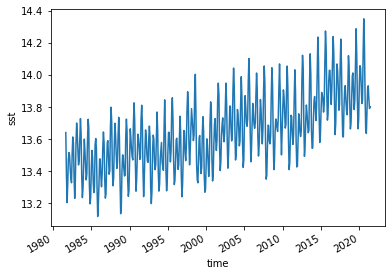

In [24]:
# Global mean SST
sst.mean(('lat','lon')).plot()

In [50]:
# Our 6 coefficient model is composed of the mean, trend, annual sine and cosine harmonics, & semi-annual sine and cosine harmonics
model = np.array([np.ones(len(dyr))] + [dyr-np.mean(dyr)] + [np.sin(2*np.pi*dyr)] + [np.cos(2*np.pi*dyr)] + [np.sin(4*np.pi*dyr)] + [np.cos(4*np.pi*dyr)])

# Take the pseudo-inverse of model to 'solve' least-squares problem
pmodel = np.linalg.pinv(model)

# Convert model and pmodel to xaray DataArray
model_da = xr.DataArray(model.T, dims=['time','coeff'], coords={'time':sst.time.values, 'coeff':np.arange(1,7,1)}) 
pmodel_da = xr.DataArray(pmodel.T, dims=['coeff','time'], coords={'coeff':np.arange(1,7,1), 'time':sst.time.values})  

# resulting coefficients of the model
sst_mod = xr.DataArray(pmodel_da.dot(sst), dims=['coeff','lat','lon'], coords={'coeff':np.arange(1,7,1), 'lat':sst.lat.values, 'lon':sst.lon.values})


In [51]:
# Construct mean, trend, and seasonal cycle
mean = model_da[:,0].dot(sst_mod[0,:,:])
trend = model_da[:,1].dot(sst_mod[1,:,:])
seas = model_da[:,2:].dot(sst_mod[2:,:,:])

In [56]:
# compute anomalies by removing all  the model coefficients 
ssta_notrend = sst-model_da.dot(sst_mod)

### Standardized SSTa by dividing by the monthly standard deviation
This step places equal variance on SSTa at all spatial points

In [57]:
# Compute the monthly standard deviation
stdev = ssta_notrend.groupby(ssta_notrend.time.dt.month).std()

In [58]:
# Divide by standard deviation
ssta_stn_notrend = ssta_notrend.groupby(ssta_notrend.time.dt.month) / stdev

### Use a threshold to find extreme anomalies

In [80]:
# Use the 90th percentile as a threshold and find anomalies that exceed it. 

if ssta_stn_notrend.chunks:
    ssta_stn_notrend = ssta_stn_notrend.chunk({'time': -1})

threshold = ssta_stn_notrend.quantile(.9, dim=('time'))
features_notrend = ssta_notrend.where(ssta_stn_notrend>=threshold, other=np.nan)


In [90]:
# Add a land/ocean mask
mask = np.isfinite(sst.isel(time=0))

# xarray Dataset to save
ds_out = xr.Dataset(
    data_vars=dict(
        features_notrend=(['time','lat','lon'], features_notrend.values),
        ssta_notrend=(['time','lat','lon'], ssta_notrend.values),
        stdev=(['month','lat','lon'], stdev.values),
        mask=(['lat','lon'], mask.values),
    ),
    coords=dict(
        lon=ds.lon,
        lat=ds.lat,
        time=ds.time,
        month=stdev.month,
    ),
    attrs=dict(description="OISST v2.1 preprocessed for Ocetrac",
              threshold='90th percentile',
              climatology='entire period'),
)
ds_out

<xarray.Dataset>
Dimensions:           (time: 478, lat: 720, lon: 1440, month: 12)
Coordinates:
  * lon               (lon) float32 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * lat               (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * time              (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2021-06-01
  * month             (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    features_notrend  (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    ssta_notrend      (time, lat, lon) float64 nan nan nan ... -0.1364 -0.1362
    stdev             (month, lat, lon) float64 nan nan nan ... 0.0544 0.05447
    mask              (lat, lon) bool False False False False ... True True True
Attributes:
    description:  OISST v2.1 preprocessed for Ocetrac
    threshold:    90th percentile
    climatology:  entire period

### Save data at a netCDF

In [92]:
ds_out.to_netcdf('01_preprocess.nc', mode='w')